# Brain Tumor Detection and Classification
In this project I am using the kaggle data set with MRI images of brain tumors (https://www.kaggle.com/datasets/thomasdubail/brain-tumors-256x256) to develop a CNN model to detect and classify brain tumors in MRI images into four categories: (no tumor, glioma tumor, meningioma tumor and pituitary tumor). In the directory each sub-directory contains only images belonging to one class. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

In [2]:
plt.rcParams['figure.dpi'] = 100
%config InlineBackend.figure_format = 'svg'

### Data Directory

In [2]:
path = '/Users/aneesh/Documents/Kaggle/brain_tumor_4class/Data'

### Load the images into tensorflow dataset
This code will load all images from all the subdirectories and label them (class = sub directory). It returns training and validation sets (0.9:0.1) in the tensorflow dataset format. Images are batched into size of 32 and resized to 224x224 (this is the input size for Xception)

In [4]:
train_ds, valid_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  labels='inferred',
  class_names=['normal', 'glioma_tumor','meningioma_tumor','pituitary_tumor'],
  validation_split=0.1,
  subset="both",
  label_mode='categorical',
  color_mode='rgb',
  seed=123,
  batch_size=32,
  image_size=(224, 224),
  shuffle=True,
#   data_format='channel_last'
  )

Found 3096 files belonging to 4 classes.
Using 2787 files for training.
Using 309 files for validation.


#### Make sure data has been properly loaded as batches

In [5]:
image, label = next(iter(train_ds))
print(image.shape)
print(label.shape)

(32, 224, 224, 3)
(32, 4)


In [6]:
label[31]

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0., 0., 1., 0.], dtype=float32)>

## Plot random images from each category

normal


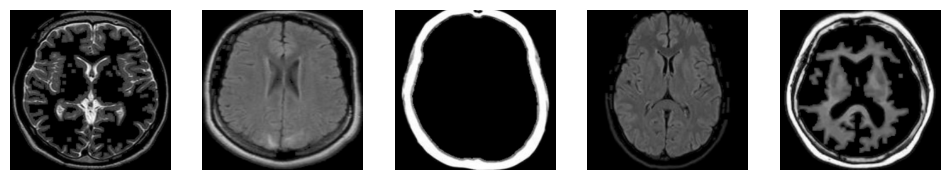

glioma_tumor


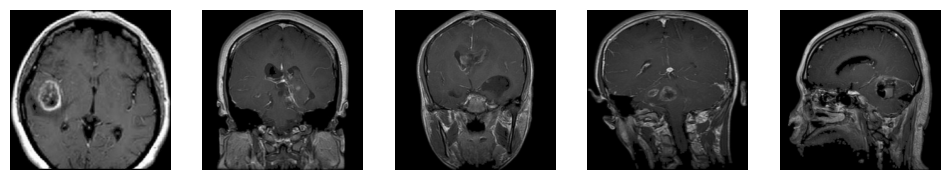

meningioma_tumor


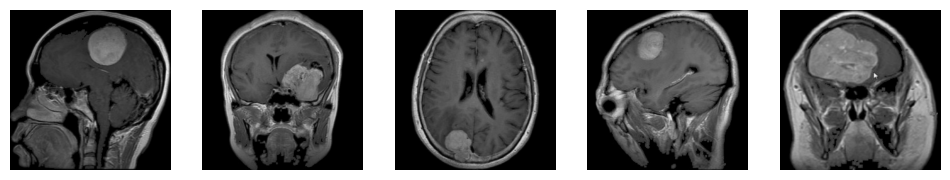

pituitary_tumor


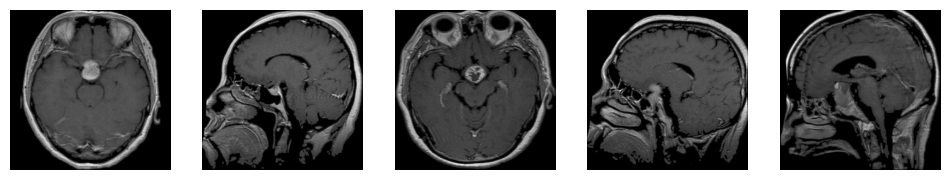

In [5]:
import os
class_names = train_ds.class_names
num_images_per_class = 5
for x in class_names:
    print(x)
    subpath = path + '/' + x
    files = os.listdir(subpath)
    indexes = np.random.randint(0, len(files), num_images_per_class)
    fig, ax = plt.subplots(1, num_images_per_class, figsize=(12, 10))
    for i, idx in enumerate(indexes):
        img = plt.imread(subpath + '/' + files[idx])
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

#### I am using the pretrained model Xception
First send the images through the preprocessing pipeline of the Xception

In [8]:
def preprocess(image, label):
    # resized_image = tf.image.resize(image, [224, 224])
    final_image = tf.keras.applications.xception.preprocess_input(image) 
    return final_image, label

In [9]:
training_ds = train_ds.map(preprocess).prefetch(1)
validation_ds = valid_ds.map(preprocess).prefetch(1)

## Define the Model
Here we load the pretrained Xception architecture and remove its top layers. Then we add a global average pooling layer and then a dense layer. We will train only the top 15 layers of the base model and the dense layer.  Note that the dense layer should have n_classes number of neurons. Softmax activation function is used because we have to classify images into multiple categories.

In [9]:
n_classes = 4
base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [10]:
for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers[-15:]:
    layer.trainable = True

### Early stopping condition
This is to stop training when the validation loss has hit a minimum.
The second part is for saving checkpoints

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.005, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True
)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "best_model.h5",
    save_best_only=True,
    monitor="val_loss",
    mode="min"
)

### Optimizer
I am using the adam optimizer with a low learning rate to avoid ruining the pretrained layers.

In [12]:
# optimizer = tf.keras.optimizers.legacy.SGD(lr=0.001, momentum=0.9, decay=0.01)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])
history = model.fit(training_ds, epochs=150, validation_data=validation_ds, callbacks=[early_stopping, checkpoint_callback])

Epoch 1/150


2024-01-29 00:54:20.049394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - ETA: 0s - loss: 0.6586 - accuracy: 0.7686

/Users/aneesh/miniconda3/envs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/88 [==============================] - 22s 225ms/step - loss: 0.6586 - accuracy: 0.7686 - val_loss: 0.6353 - val_accuracy: 0.7540
Epoch 2/150
88/88 [==============================] - 19s 211ms/step - loss: 0.2314 - accuracy: 0.9243 - val_loss: 0.3356 - val_accuracy: 0.8835
Epoch 3/150
88/88 [==============================] - 19s 211ms/step - loss: 0.1190 - accuracy: 0.9699 - val_loss: 0.2166 - val_accuracy: 0.9288
Epoch 4/150
88/88 [==============================] - 19s 212ms/step - loss: 0.0658 - accuracy: 0.9885 - val_loss: 0.1739 - val_accuracy: 0.9482
Epoch 5/150
88/88 [==============================] - 18s 207ms/step - loss: 0.0487 - accuracy: 0.9932 - val_loss: 0.1779 - val_accuracy: 0.9417
Epoch 6/150
88/88 [==============================] - 19s 212ms/step - loss: 0.0248 - accuracy: 0.9982 - val_loss: 0.2152 - val_accuracy: 0.9353
Epoch 7/150
88/88 [==============================] - 21s 238ms/step - loss: 0.0177 - accuracy: 0.9982 - val_loss: 0.1558 - val_accuracy: 0.9515
Epoc

## Plot accuracy evolution
We can see that the model has saturated at around ~10 epochs

(0.0, 1.0)

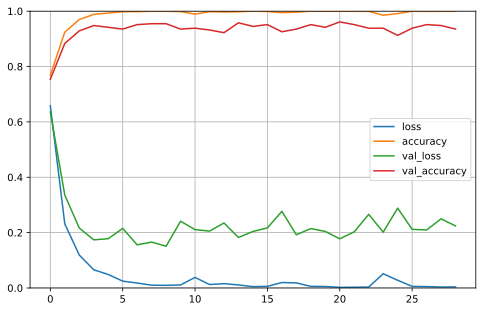

In [13]:
pd.DataFrame(history.history).plot(figsize=(8, 5)) 
plt.grid(True)
plt.gca().set_ylim(0, 1.0)

### Print the best validation accuracy

In [14]:
validation_loss, validation_accuracy = model.evaluate(validation_ds)

print(f'Validation Accuracy: {validation_accuracy * 100:.2f}%')

10/10 [==============================] - 2s 155ms/step - loss: 0.1507 - accuracy: 0.9547
Validation Accuracy: 95.47%


### Check the number of correctly classified images in the validation set

In [10]:
#load best model
model = tf.keras.models.load_model('best_model.h5')

In [11]:
prediction = model.predict(validation_ds)
predicted_classes = np.argmax(prediction, axis=1)
# get labels from validation_ds
validation_labels = []
for images, labels in validation_ds:
    validation_labels.append(labels.numpy())
validation_labels = np.concatenate(validation_labels)
correct_labels = [np.argmax(i) for i in validation_labels]
print('Fraction of correctly classified images = ', np.sum(predicted_classes == correct_labels)/len(correct_labels))


2024-01-30 20:35:33.096225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 2s 176ms/step
Fraction of correctly classified images =  0.9546925566343042


In [17]:
# confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(correct_labels, predicted_classes)
print(cm)

[[40  0  0  0]
 [ 1 84  7  0]
 [ 0  1 84  3]
 [ 0  1  1 87]]


## Our model has achieved a 95.5 % accuracy !!!
#### In the __[_brain_tumor_detection_](https://github.com/aneeshsvn/DeepLearning_and_ComputerVision/tree/main/Brain_tumor_detection)__  project I test this model on a different dataset with much smaller sample (253 images)